In [1]:
!pip install --upgrade --force-reinstall transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.7/401.7 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.5/705.5 kB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.1/775.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
!pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.0
    Uninstalling fsspec-2024.6.0:
      Successfully uninstalled fsspec-2024.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2023.6.0 requires fsspec==2023.6.0, but you have fsspec 2024.3.1 which is incompatible.


In [2]:
import os
import pandas as pd
from datasets import Dataset, DatasetDict
from PIL import Image
from transformers import VisionEncoderDecoderModel, AutoFeatureExtractor, AutoTokenizer
import nltk

os.environ["WANDB_DISABLED"] = "true"
import json

In [3]:
if not os.path.exists('/content/data/'):

    api_token = {"username": "prabeshsharma",
                 "key": "e8929420b0f14df13c668815eef404a0"}

    with open('/content/kaggle.json', 'w') as file:
        json.dump(api_token, file)

    os.environ["KAGGLE_CONFIG_DIR"] = "/content/"

    os.system('kaggle datasets download -d adityajn105/flickr8k')
    os.makedirs('/content/data/', exist_ok=True)
    os.system('mv /content/flickr8k.zip /content/data/flickr8k.zip')
    os.system('unzip -q /content/data/flickr8k.zip -d /content/data/')
    os.remove('/content/data/flickr8k.zip')

In [4]:
import pandas as pd
import json
import os

# Load the CSV file
csv_file_path = '/content/data/captions.txt'
df = pd.read_csv(csv_file_path)

# Update the image paths in the DataFrame
images_folder_path = '/content/data/Images'
df['image'] = df['image'].apply(lambda x: os.path.join(images_folder_path, x))

# Group captions by image
grouped = df.groupby('image')['caption'].apply(list).reset_index()

# Create a dictionary with the desired format
data = {}
for index, row in grouped.iterrows():
    image_path = row['image']
    captions = row['caption']
    formatted_captions = [f"<s> {caption} <e>" for caption in captions]
    data[image_path] = formatted_captions

# Save the dictionary to a JSON file
json_file_path = 'data.json'
with open(json_file_path, 'w') as json_file:
    json.dump(data, json_file, indent=4)

print(f"JSON file has been saved to {json_file_path}")


JSON file has been saved to data.json


In [5]:
import datasets
import transformers
import pandas as pd
import torch
from torch.utils.data.dataset import Dataset
from pathlib import Path



#Tokenizer from scratch on vocabulary of corpus
from tokenizers import ByteLevelBPETokenizer

# Decoder
from transformers import RobertaConfig
from transformers import RobertaForMaskedLM # RobertaLM for learning
from transformers import RobertaTokenizerFast # After training tokenizern we will wrap it so it can be used by Roberta model


#Training
# When using previous version of the library you need the following two lines
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
from transformers import Trainer, TrainingArguments

In [6]:
TRAIN_BATCH_SIZE = 20   # input batch size for training (default: 64)
VALID_BATCH_SIZE = 5   # input batch size for testing (default: 1000)
VAL_EPOCHS = 1
LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
SEED = 42               # random seed (default: 42)
MAX_LEN = 128           # Max length for product description
SUMMARY_LEN = 20         # Max length for product names

TRAIN_EPOCHS = 2       # number of epochs to train (default: 10)
WEIGHT_DECAY = 0.01
SEED = 42               # random seed (default: 42)
MAX_LEN = 128
SUMMARY_LEN = 20   # Maximum length of caption generated by the model

In [7]:
import os
import json


with open('data.json', 'r') as openfile:

    json_object = json.load(openfile)

images_caption_dict = dict(json_object)


images_path = '/content/data/Images'
images = list(images_caption_dict.keys())

for image_path in images:
    if image_path.endswith('jpg'):
        new = images_path + image_path.split('/')[-1]
        images_caption_dict[new] = images_caption_dict.pop(image_path)
    else:
        images_caption_dict.pop(image_path)

In [8]:
import pandas as pd

df = pd.DataFrame([])

captions = []
images = []
for image in list(images_caption_dict.keys()):
    caption = images_caption_dict[image]
#     captions.append(('.'.join([ sent.rstrip() for sent in ('.'.join(caption)).split('<e>.<s>')]))\
#                             .replace('<s> ','').replace('  <e>','.'))
    for capt in caption:
        captions.append(capt.replace('<s> ','').replace('  <e>','').strip())
        images.append(image)

df['images'] = images
df['captions'] = captions

In [9]:
# Store values in a dataframe column (Series object) to files, one file per record
os.mkdir("./text_split")
def column_to_files(column, prefix, txt_files_dir = "./text_split"):
    # The prefix is a unique ID to avoid to overwrite a text file
    i=prefix
    #For every value in the df, with just one column
    for row in column.to_list():
      # Create the filename using the prefix ID
        file_name = os.path.join(txt_files_dir, str(i)+'.txt')
        try:
            # Create the file and write the column text to it
            f = open(file_name, 'wb')
            f.write(row.encode('utf-8'))
            f.close()
        except Exception as e:  #catch exceptions(for eg. empty rows)
            print(row, e)
        i+=1
    # Return the last ID
    return i

data = df["captions"]
# Removing the end of line character \n
data = data.replace("\n"," ")
# Set the ID to 0
prefix=0
# Create a file for every description value
prefix = column_to_files(data, prefix)
# Print the last ID

In [10]:
%%time
paths = [str(x) for x in Path(".").glob("text_split/*.txt")]

# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer(lowercase=True)

# Customize training
tokenizer.train(files=paths, vocab_size=10000, min_frequency=2,
                show_progress=True,
                special_tokens=[
                                "<s>",
                                "<pad>",
                                "<e>",
                                "<unk>",
                                "<mask>",
])

CPU times: user 2.34 s, sys: 812 ms, total: 3.15 s
Wall time: 3.22 s


In [11]:
os.mkdir('Byte_tokenizer')
tokenizer.save_model('Byte_tokenizer')

['Byte_tokenizer/vocab.json', 'Byte_tokenizer/merges.txt']

In [12]:
config = RobertaConfig(
    vocab_size=10000,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)

model = RobertaForMaskedLM(config=config)

print('Num parameters: ',model.num_parameters())

# Create the tokenizer from a trained one
tokenizer = RobertaTokenizerFast.from_pretrained('Byte_tokenizer', max_len=MAX_LEN)

Num parameters:  51206416


In [13]:
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer):
        # or use the RobertaTokenizer from `transformers` directly.

        self.examples = []

        for example in df.values:
            x=tokenizer.encode_plus(example, max_length = MAX_LEN, truncation=True, padding=True)
            self.examples += [x.input_ids]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        # We’ll pad at the batch level.
        return torch.tensor(self.examples[i])

In [14]:
# Create the train and evaluation dataset
train_dataset = CustomDataset(df['captions'][:38000], tokenizer)
eval_dataset = CustomDataset(df['captions'][38000:], tokenizer)

In [15]:
from transformers import DataCollatorForLanguageModeling

# Define the Data Collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

In [16]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [17]:
from transformers import TrainingArguments, Trainer
model_folder = "RobertaMLM"
# Define the training arguments
training_args = TrainingArguments(
    output_dir=model_folder,
    overwrite_output_dir=True,
    evaluation_strategy = 'epoch',
    num_train_epochs=TRAIN_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=VALID_BATCH_SIZE,
    save_steps=8192,
    #eval_steps=4096,
    save_total_limit=1,
)
# Create the trainer for our model
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    #prediction_loss_only=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [18]:
# Train the model
trainer.train()

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch,Training Loss,Validation Loss
1,3.572600,3.066483
2,2.765400,2.638992


TrainOutput(global_step=3800, training_loss=3.3621738313373766, metrics={'train_runtime': 323.7976, 'train_samples_per_second': 234.715, 'train_steps_per_second': 11.736, 'total_flos': 526664470112640.0, 'train_loss': 3.3621738313373766, 'epoch': 2.0})

In [19]:
import math
eval_results = trainer.evaluate()

print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

Perplexity: 13.97


In [20]:
tokenizer.save_pretrained('Byte_tokenizer')

('Byte_tokenizer/tokenizer_config.json',
 'Byte_tokenizer/special_tokens_map.json',
 'Byte_tokenizer/vocab.json',
 'Byte_tokenizer/merges.txt',
 'Byte_tokenizer/added_tokens.json',
 'Byte_tokenizer/tokenizer.json')

In [21]:
trainer.save_model(model_folder)

In [22]:
from transformers import pipeline

fill_mask = pipeline(
    "fill-mask",
    model= r'RobertaMLM',
    tokenizer= 'Byte_tokenizer'
)

In [23]:
fill_mask("a girl going into a <mask> building")

[{'score': 0.12766174972057343,
  'token': 73,
  'token_str': 'e',
  'sequence': 'a girl going into ae building'},
 {'score': 0.04155125468969345,
  'token': 263,
  'token_str': ' <',
  'sequence': 'a girl going into a < building'},
 {'score': 0.016751524060964584,
  'token': 649,
  'token_str': ' park',
  'sequence': 'a girl going into a park building'},
 {'score': 0.016548939049243927,
  'token': 479,
  'token_str': ' rock',
  'sequence': 'a girl going into a rock building'},
 {'score': 0.016214165836572647,
  'token': 265,
  'token_str': '.',
  'sequence': 'a girl going into a. building'}]

In [ ]:
!pip install dataset

In [24]:
import datasets
import transformers
import pandas as pd
import torch
from torch.utils.data.dataset import Dataset
from pathlib import Path



#Tokenizer from scratch on vocabulary of corpus
from tokenizers import ByteLevelBPETokenizer

# Decoder
from transformers import RobertaConfig
from transformers import RobertaForMaskedLM # RobertaLM for learning
from transformers import RobertaTokenizerFast # After training tokenizern we will wrap it so it can be used by Roberta model



#Encoder-Decoder Model
from transformers import VisionEncoderDecoderModel

#Training
# When using previous version of the library you need the following two lines
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
from transformers import Trainer, TrainingArguments
import os
import json

In [25]:
TRAIN_BATCH_SIZE = 20   # input batch size for training (default: 64)
VALID_BATCH_SIZE = 5   # input batch size for testing (default: 1000)
VAL_EPOCHS = 1
LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
SEED = 42               # random seed (default: 42)
MAX_LEN = 128           # Max length for product description
SUMMARY_LEN = 20         # Max length for product names

TRAIN_EPOCHS = 2       # number of epochs to train (default: 10)
WEIGHT_DECAY = 0.01
SEED = 42               # random seed (default: 42)
MAX_LEN = 128
SUMMARY_LEN = 20   # Maximum length of caption generated by the model

In [26]:
import os
# os.chdir(r'C:\Users\kalpe\Dropbox\PC\Documents\Great lakes\ML project')
import json


with open('data.json', 'r') as openfile:

    json_object = json.load(openfile)

images_caption_dict = dict(json_object)


images_path = '/content/data/Images/'
images = list(images_caption_dict.keys())

for image_path in images:
    if image_path.endswith('jpg'):
        new = images_path + image_path.split('/')[-1]
        images_caption_dict[new] = images_caption_dict.pop(image_path)
    else:
        images_caption_dict.pop(image_path)

In [27]:
import random
def train_test_split(dictionary):
    images = dictionary.keys()
    images_test = random.sample(images,int(0.3*len(images)))
    images_train = [img for img in images if img not in images_test]

    train_dict = {
      img: dictionary[img] for img in images_train
    }

    test_dict = {
      img: dictionary[img] for img in images_test
    }
    return(train_dict,test_dict)

train,test = train_test_split(images_caption_dict)

<ipython-input-27-3a9e9bcf1976>:4: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  images_test = random.sample(images,int(0.3*len(images)))


In [28]:
import pandas as pd

def get_df(dictionary):
    df = pd.DataFrame([])

    captions = []
    images = []
    for image in list(images_caption_dict.keys()):
        caption = images_caption_dict[image]
    #     captions.append(('.'.join([ sent.rstrip() for sent in ('.'.join(caption)).split('<e>.<s>')]))\
    #                             .replace('<s> ','').replace('  <e>','.'))
        for capt in caption:
            captions.append(capt.replace('<s> ','').replace('  <e>','').strip())
            images.append(image)

    df['images'] = images
    df['captions'] = captions
    return(df)

train_df = get_df(train)
test_df = get_df(test)

In [29]:
train_df

,images,captions
0,/content/data/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,/content/data/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building . <e>
2,/content/data/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse...
3,/content/data/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,/content/data/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,/content/data/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face <e>
40451,/content/data/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air . <e>
40452,/content/data/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,/content/data/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt . <e>


In [30]:
from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained('Byte_tokenizer', max_len=MAX_LEN)

In [31]:
from transformers import ViTFeatureExtractor, ViTModel
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [32]:
import torch
from torch.utils.data import Dataset
from PIL import Image

batch_size=TRAIN_BATCH_SIZE  # change to 16 for full training

class IAMDataset(Dataset):
    def __init__(self, df, tokenizer,feature_extractor, decoder_max_length=31):
        self.df = df
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.decoder_max_length = decoder_max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        img_path = self.df['images'][idx]
        caption = self.df['captions'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(img_path).convert("RGB")
        pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.tokenizer(caption, truncation = True,
                                          padding="max_length",
                                          max_length=self.decoder_max_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

train_dataset = IAMDataset(df=train_df.sample(frac=0.3,random_state=2).iloc[:10000].reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,
                          feature_extractor= feature_extractor)
eval_dataset = IAMDataset(df=test_df.sample(frac=0.1,random_state=2)[:2000].reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,feature_extractor= feature_extractor)

In [33]:
# set encoder decoder tying to True
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained\
                    ("google/vit-base-patch16-224-in21k", 'RobertaMLM', tie_encoder_decoder=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of RobertaForCausalLM were not initialized from the model checkpoint at RobertaMLM and are newly initialized: ['roberta.encoder.layer.0.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.0.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.0.crossattention.output.dense.bias', 'roberta.encoder.layer.0.crossattention.output.dense.weight', 'roberta.encoder.layer.0.crossattention.self.key.bias', 'roberta.encoder.layer.0.crossattention.self.key.weight', 'roberta.encoder.layer.0.crossattention.self.query.bias', 'roberta.encoder.layer.0.crossattention.self.query.weight', 'roberta.encoder.layer.0.crossattention.self.value.bias', 'roberta.encoder.layer.0.crossattention.self.value.weight', 'roberta.encoder.layer.1.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.1.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.1.crossattention.output.dense.bias', 'roberta.encoder.layer.1.crossattention.output.dense.weight', 'roberta.encoder.layer

In [34]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = 20
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [35]:

!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=c2e6e2cee6654f58ff366301a33815a3cb2e4cf3f9291dca1d51feefa70603f2
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [36]:
# load rouge for validation
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

<ipython-input-36-4324511b13f7>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = datasets.load_metric("rouge")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [37]:
captioning_model = 'VIT_Captioning'

training_args = Seq2SeqTrainingArguments(
    output_dir=captioning_model,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    #evaluate_during_training=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,
    save_steps=2048,
    warmup_steps=1024,
    #max_steps=1500, # delete for full training
    num_train_epochs = TRAIN_EPOCHS, #TRAIN_EPOCHS
    overwrite_output_dir=True,
    save_total_limit=1,
)

from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [38]:
# Fine-tune the model, training and evaluating on the train dataset
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
1,No log,2.741238,0.065800,0.058100,0.059700
2,No log,2.431926,0.090600,0.090700,0.087800


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1283: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


TrainOutput(global_step=1000, training_loss=3.1710234375, metrics={'train_runtime': 1291.573, 'train_samples_per_second': 15.485, 'train_steps_per_second': 0.774, 'total_flos': 2.59576928206848e+18, 'train_loss': 3.1710234375, 'epoch': 2.0})

In [39]:
trainer.save_model('Image_Cationing_VIT_Roberta_iter2')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


In [40]:
t = VisionEncoderDecoderModel.from_pretrained('Image_Cationing_VIT_Roberta_iter2')

The following encoder weights were not tied to the decoder ['vision_encoder_decoder/pooler', 'vision_encoder_decoder/encoder', 'vision_encoder_decoder/embeddings', 'vision_encoder_decoder/layernorm']
The following encoder weights were not tied to the decoder ['vision_encoder_decoder/pooler', 'vision_encoder_decoder/encoder', 'vision_encoder_decoder/embeddings', 'vision_encoder_decoder/layernorm']
The following encoder weights were not tied to the decoder ['vision_encoder_decoder/pooler', 'vision_encoder_decoder/encoder', 'vision_encoder_decoder/embeddings', 'vision_encoder_decoder/layernorm']


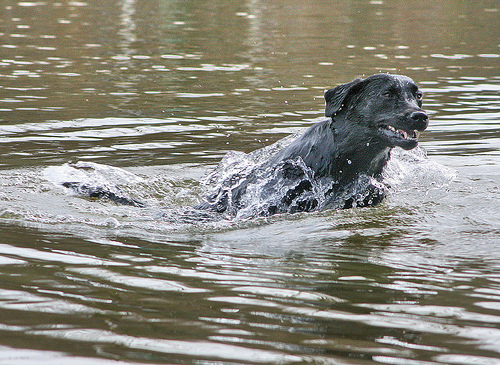

In [70]:
temp = test_df.sample(11).images.iloc[0]
Image.open(temp).convert("RGB")

In [71]:
tokenizer.decode(t.generate(feature_extractor(Image.open(temp).convert("RGB"), return_tensors="pt").pixel_values)[0])

'<s><s>A black and white dog is running through the water. <e></s>'